## 📝 Section 2: Statistical Analysis with SciPy & Statsmodels  

In [69]:
# Install necessary Libraries
%pip install pandas numpy scipy statsmodels matplotlib seaborn ta-lib backtrader --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [82]:
# Import necessary libraries

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import pandas as pd
from collections import Counter


In [71]:
# Initialize variables
ticker = 'NVDA'
start_date = '2023-01-01'
end_date = '2024-01-01'

### TASK 1: Generate Distributions

***WHAT IS A NORMAL DISTRIBUTION?***   
A normal distribution is a probability distribution that is symmetric about the mean, showing that data near the mean are more frequent in occurrence than data far from the mean. In graph form, normal distribution will appear as a bell curve.

**WHAT IS A LOGNORMAL DISTRIBUTION?**   
A lognormal distribution is a probability distribution of a random variable whose logarithm is normally distributed. If the logarithm of a variable has a normal distribution, then the variable has a log-normal distribution.

**WHAT IS A STUDENT'S T-DISTRIBUTION?**   
A Student's t-distribution (or simply t-distribution) is a probability distribution that is used to estimate the mean of a normally distributed population when the sample size is small and the population standard deviation is unknown.

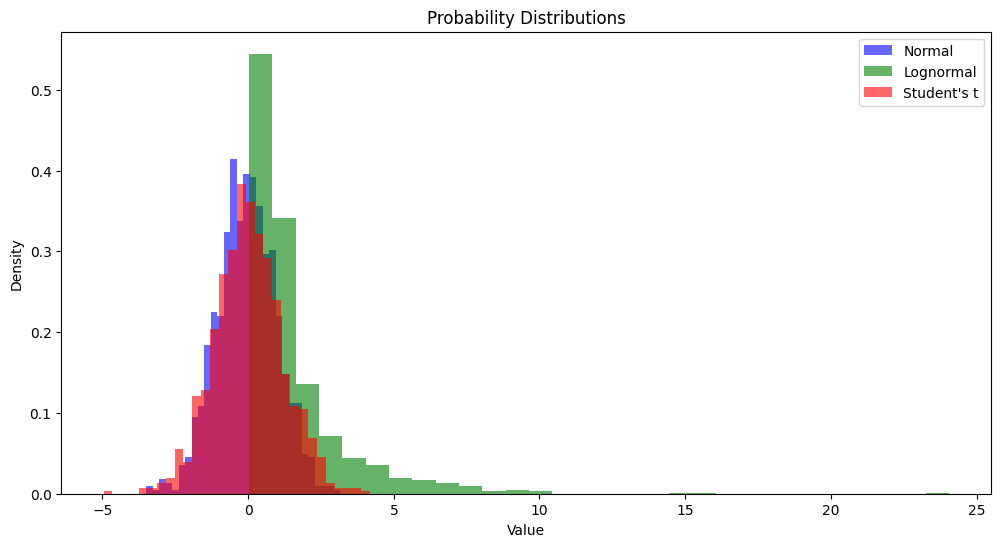

In [72]:
x = np.linspace(-4, 4, 1000)

# Generate samples
normal_data = np.random.normal(0, 1, 1000)
lognormal_data = np.random.lognormal(0, 1, 1000)
t_data = np.random.standard_t(df=10, size=1000)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(normal_data, bins=30, alpha=0.6, color='blue', label='Normal', density=True)
plt.hist(lognormal_data, bins=30, alpha=0.6, color='green', label='Lognormal', density=True)
plt.hist(t_data, bins=30, alpha=0.6, color='red', label="Student's t", density=True)

plt.legend()
plt.title("Probability Distributions")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

### TASK 1.2: Fit stocks returns to Normal and t-Distributions

In [73]:
#Download and process stock data
stock = yf.download(ticker, start=start_date, end=end_date)
stock['Returns'] = stock['Close'].pct_change()
stock = stock.dropna()  # Remove NaN values

[*********************100%***********************]  1 of 1 completed


In [74]:
#Fit returns to normal distribution and t-distribution
mu, sigma = stats.norm.fit(stock['Returns'])
df, loc, scale = stats.t.fit(stock['Returns'])

ks_norm = stats.kstest(stock['Returns'], 'norm', args=(mu, sigma))
ks_t = stats.kstest(stock['Returns'], 't', args=(df, loc, scale))

# Print results
print(f"MU: {mu:.5f}, SIGMA: {sigma:.5f}")
print(f"Kolmogorov-Smirnov test for Normal distribution: p-value = {ks_norm.pvalue:.5f}")

print(f"DF: {df:.2f}, LOC: {loc:.5f}, SCALE: {scale:.5f}")
print(f"Kolmogorov-Smirnov test for Student's t-distribution: p-value = {ks_t.pvalue:.5f}")

# Interpretation
if ks_norm.pvalue > 0.05:
    print("Returns are likely normally distributed (Fail to reject H0).")
else:
    print("Returns are NOT normally distributed (Reject H0).")

if ks_t.pvalue > 0.05:
    print("Returns are likely t-distributed (Fail to reject H0).")
else:
    print("Returns are NOT t-distributed (Reject H0).")

MU: 0.00544, SIGMA: 0.03046
Kolmogorov-Smirnov test for Normal distribution: p-value = 0.06662
DF: 4.79, LOC: 0.00360, SCALE: 0.02168
Kolmogorov-Smirnov test for Student's t-distribution: p-value = 0.98742
Returns are likely normally distributed (Fail to reject H0).
Returns are likely t-distributed (Fail to reject H0).


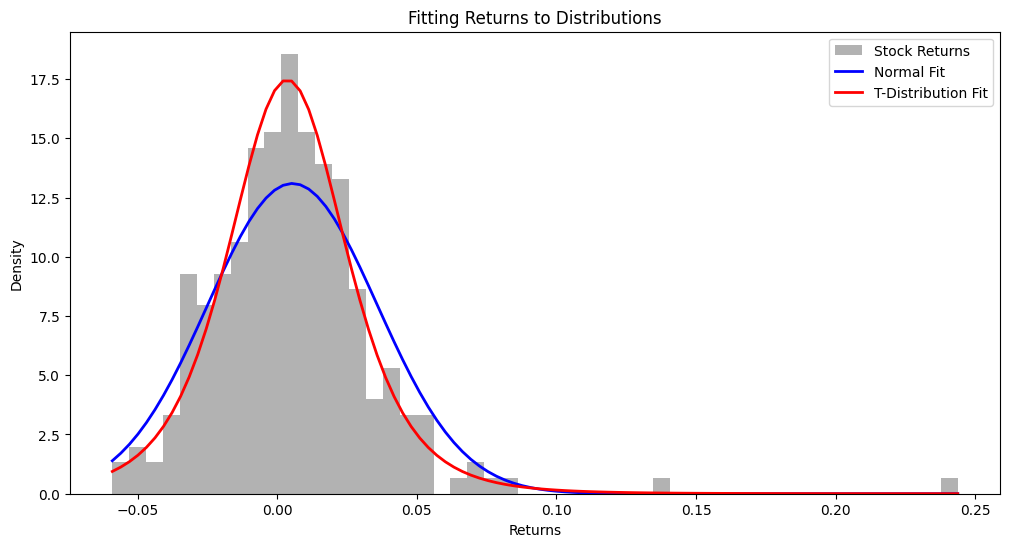

In [75]:
# Plot returns and fitted distributions
plt.figure(figsize=(12, 6))

# Histogram of stock returns
plt.hist(stock['Returns'], bins=50, alpha=0.6, color='gray', label="Stock Returns", density=True)

# Generate x values
x = np.linspace(stock['Returns'].min(), stock['Returns'].max(), 100)

# Plot fitted normal and t-distributions
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal Fit", color="blue", linewidth=2)
plt.plot(x, stats.t.pdf(x, df, loc, scale), label="T-Distribution Fit", color="red", linewidth=2)

plt.legend()
plt.title("Fitting Returns to Distributions")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.show()


### TASK 2: Hypothesis testing on Market Events

In [76]:
# Get earnings dates

stock = yf.Ticker(ticker)
earnings = stock.earnings_dates  # Get earnings dates
earnings_date = None
earnings = pd.DataFrame(earnings)
earnings.dropna(inplace=True)
print(earnings)
earnings_date = None
if not earnings.empty:
    # Convert earnings.index to timezone-naive
    earnings.index = earnings.index.tz_localize(None)

    # Get the most recent past earnings date
    earnings_date = pd.to_datetime(earnings[earnings.index < pd.Timestamp.today()].index.max()) # First earnings date

print(f"First earnings date: {earnings_date}")

                           EPS Estimate  Reported EPS  Surprise(%)
Earnings Date                                                     
2025-02-25 19:00:00-05:00          0.84          0.89         5.45
2024-11-19 19:00:00-05:00          0.75          0.81         8.58
2024-08-27 20:00:00-04:00          0.64          0.68         6.03
2024-05-21 20:00:00-04:00          0.56          0.61         9.48
2024-02-20 19:00:00-05:00          4.64          5.16        11.32
2023-11-20 19:00:00-05:00          3.37          4.02        19.21
2023-08-22 20:00:00-04:00          2.09          2.70        29.41
First earnings date: 2025-02-25 19:00:00


In [79]:
# Get pre-earnings and post-earnings returns

days = 5 # Number of days to consider

stock = yf.download(ticker, start=earnings_date - pd.Timedelta(days=days+5), 
                        end=earnings_date + pd.Timedelta(days=days+5))
stock['Returns'] = stock['Close'].pct_change()
stock = stock.dropna()

pre_earnings = stock.loc[:earnings_date].tail(days)['Returns']
post_earnings = stock.loc[earnings_date:].head(days)['Returns']

[*********************100%***********************]  1 of 1 completed


### TASK 2.1: Conduct a t-test

**WHAT IS A T-TEST?**   
A t-test is a statistical test used to determine if there is a significant difference between the means of two groups. It is commonly used to compare the means of two samples to assess whether they are statistically different from each other.

In [80]:

# Perform Levene’s test to check variance equality
levene_stat, p_val_levene = stats.levene(pre_earnings, post_earnings)

# Decide whether to assume equal variance
equal_var = p_val_levene > 0.05  # True if p-value is high (variances are similar)
t_stat, p_value = stats.ttest_ind(pre_earnings, post_earnings, equal_var=equal_var)

# Print results
print(f"Levene’s test p-value: {p_val_levene:.5f} → Equal variance: {equal_var}")
print(f"T-test p-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Significant difference in returns pre- vs. post-earnings!")
else:
    print("No significant difference in returns pre- vs. post-earnings.")


Levene’s test p-value: 0.17461 → Equal variance: True
T-test p-value: 0.91875
No significant difference in returns pre- vs. post-earnings.


### TASK 2.2 Conduct a chi-square test for chekcing if high-volume trading days follow expected distributions.

**WHAT IS A CHI-SQUARE TEST?**  
A chi-square test is a statistical test used to determine whether there is a significant association between two categorical variables. 
The test is based on the difference between the expected frequencies and the observed frequencies in one or more categories.

In [104]:
# Get high volume days
volume_threshold = stock['Volume'].quantile(0.90)  # 90th percentile
high_volume_days = stock['Volume'] > volume_threshold

# Ensure high_volume_days is 1-dimensional
high_volume_days = high_volume_days.squeeze()

# Calculate chi-squared test and plot hypothesis
contingency_table = pd.crosstab(high_volume_days, (stock['Returns'] > 0).squeeze())
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Print results
print(f"Chi-squared test p-value: {p:.5f}")
if p < 0.05:
    print("Significant relationship between high volume days and positive returns!")
else:
    print("No significant relationship between high volume days and positive returns.")


Chi-squared test p-value: 0.51416
No significant relationship between high volume days and positive returns.


### TASK 3: Rgression Models

**WHATH IS A REGRESSION MODEL?**   
A regression model is a statistical model that estimates the relationship between one or more independent variables and a dependent variable.
The goal is to predict the dependent variable based on the independent variables.   

**SOME TYPES OF REGRESSION MODELS**   
1. **Linear Regression:** Simple linear regression models the relationship
between a dependent variable and one independent variable.
2. **Multiple Regression:** Multiple regression models the relationship
between a dependent variable and multiple independent variables.
3. **Polynomial Regression:** Polynomial regression models the relationship
between a dependent variable and independent variables raised to a power.
4. **Logistic Regression:** Logistic regression models the relationship
between a binary dependent variable and independent variables.